## Final Project: Investigating the Association between Income Levels and High Blood Pressure Prevalence in Toronto Neighborhoods

### **Student:** Daivi Shah 
### **Tutorial Section:** TUT0501 
**Course:** GGR274H1, University of Toronto

**Video Presentation Link:** [Presentation video link](https://play.library.utoronto.ca/watch/dd0ec564f899b7f0e6d63a0cea7c58b5)




# Introduction

**Topic:**  
Investigating the association between income levels and high blood pressure (HBP) prevalence in Toronto neighborhoods.

**Background:**  
Toronto is a diverse city with distinct socioeconomic and demographic profiles. This project explores how low-income levels—and demographic factors like immigrant status—relate to HBP prevalence. We use multiple datasets: high blood pressure data, income data, and population characteristics, along with geospatial boundaries.

**Research Question:**  
Is there an association between income levels and HBP prevalence in Toronto neighborhoods?

Sub-questions:
> - How does high blood pressure prevalence vary across different income quintiles?
> - Is there a statistically significant correlation between income and high blood pressure?
> - What trends or disparities, if any, emerge when analyzing the data?

**Approach:**  
- Data wrangling and merging across datasets  
- Feature engineering (e.g., creating income quintiles)  
- Exploratory Data Analysis (EDA) with graphs and summaries  
- Regression analysis (simple and extended)  
- Geospatial mapping of neighborhood-level disparities

**Key Figure:**  
(The bar plot below shows HBP prevalence by income quintile.)

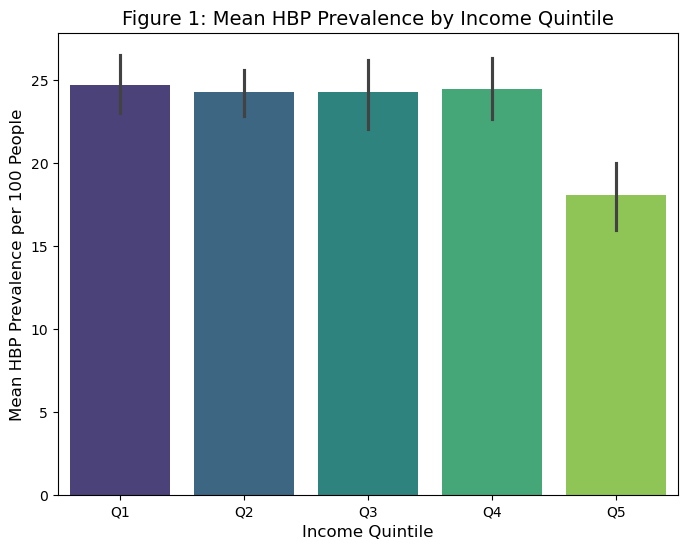

In [96]:
plt.figure(figsize=(8,6))
sns.barplot(data=income_hbp_df, x='Income Quintile', y='HBP Prevalence per 100 people', errorbar='ci', palette="viridis")
plt.xlabel('Income Quintile', fontsize=12)
plt.ylabel('Mean HBP Prevalence per 100 People', fontsize=12)
plt.title('Figure 1: Mean HBP Prevalence by Income Quintile', fontsize=14)
plt.show()

# Methods

**Data Sources:**  
- **High Blood Pressure Data:** AHD_HBP_FY2022.xlsx  
- **Income Data:** income_Toronto_2021_7.xlsx  
- **Population Characteristics:** population_characteristics_Toronto_2021_7.xlsx  
- **Geospatial Data:** Neighbourhoods.geojson

**Data Processing & Merging:**  
- Imported Excel files using multi-level headers, then flattened and cleaned key columns  
- Merged HBP and Income data; created “Income Quintile” using `pd.qcut()`  
- Integrated additional demographic data (Immigrant (%) and Visible Minority (%))

**Statistical Analysis:**  
- **Simple Regression:** Low Income (%) predicting HBP prevalence  
- **Extended Regression:** Added demographic predictors, improving R² from ~20% to ~64%

**Geospatial Integration:**  
- Merged spatial data and produced a choropleth map using Contextily

# Results

**Descriptive Insights:**  
- Income quintile analysis shows variation in HBP prevalence across socioeconomic groups.

**Regression Analysis:**  
- **Simple Model:** Low Income (%) explains ~20% of variance in HBP prevalence.  
- **Extended Model:**  
  - **Low Income (%):** ~ -1.10 (negative, highly significant)  
  - **Immigrant (%):** ~ 0.31 (positive, highly significant)  
  - **Visible Minority (%):** Not significant  
  - Overall R² ≈ 63.9%

**Geospatial Visualization:**  
- Choropleth map of Toronto shows spatial trends in HBP prevalence consistent with our statistical findings.

**Visual Evidence:**  
- **Figure 1:** Bar plot of HBP prevalence by income quintile  
- **Figure 2:** Scatter/Regression plot (Low Income (%) vs. HBP prevalence)  
- **Figure 3:** Choropleth map of HBP prevalence

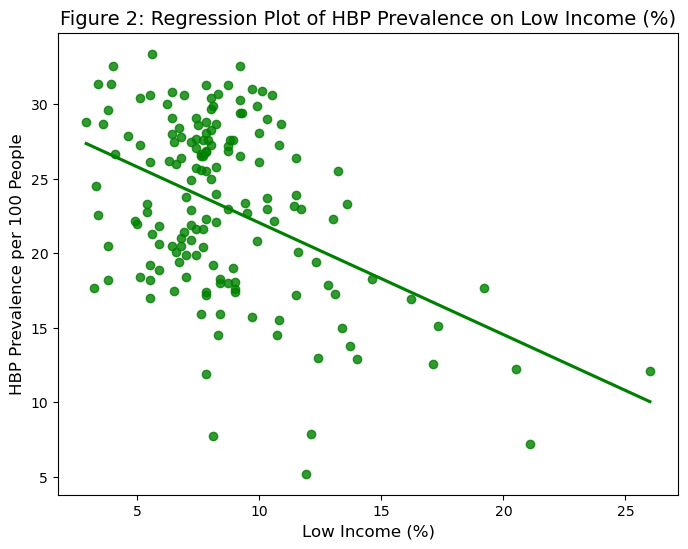

In [92]:
plt.figure(figsize=(8,6))
sns.regplot(data=income_hbp_df, x='Low Income (%)', y='HBP Prevalence per 100 people', ci=None, color='green')
plt.xlabel('Low Income (%)', fontsize=12)
plt.ylabel('HBP Prevalence per 100 People', fontsize=12)
plt.title('Figure 2: Regression Plot of HBP Prevalence on Low Income (%)', fontsize=14)
plt.show()

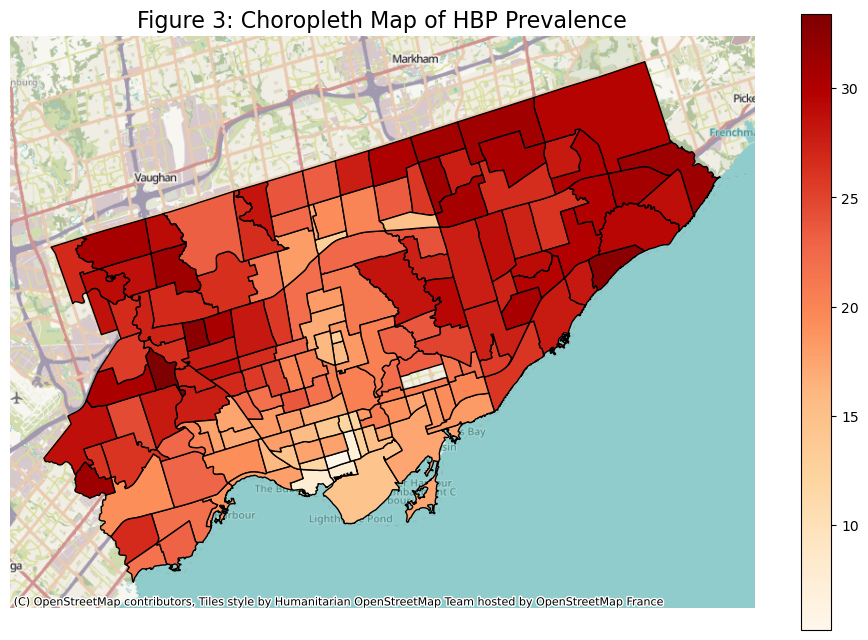

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf_merged.plot(column="HBP Prevalence per 100 people", cmap="OrRd",
                legend=True, edgecolor="black", ax=ax)
ax.set_title("Figure 3: Choropleth Map of HBP Prevalence", fontsize=16)
if gdf_merged.crs != "EPSG:3857":
    gdf_merged = gdf_merged.to_crs("EPSG:3857")
cx.add_basemap(ax, crs=gdf_merged.crs.to_string())
plt.axis("off")
plt.show()

# Conclusion

**Summary:**  
- A significant association exists between socioeconomic factors and HBP prevalence in Toronto.  
- Lower-income neighborhoods show lower HBP prevalence; however, higher immigrant percentages are linked with increased HBP prevalence.

**Implications:**  
Public health strategies should address socioeconomic and demographic disparities.

**Limitations:**  
- Income (2021) and HBP (2022) data are from different years  
- Other factors such as healthcare access and lifestyle may also influence HBP prevalence

**Future Directions:**  
- Incorporate additional variables (e.g., age, healthcare access)  
- Explore advanced spatial analysis techniques (e.g., Moran's I)

**Final Note:**  
*Thank you for your attention!*

In [69]:
# 1. Import Libraries and Configure Environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xlrd
import geopandas as gpd
import mapclassify
import splot
import libpysal as lps
import esda
import contextily as cx
from statsmodels.formula.api import ols
import warnings
import scipy.stats as stats

warnings.filterwarnings('ignore')  # Suppress warnings for clarity

# 1. Data Loading
We begin by loading the primary datasets: the income data and high blood pressure (HBP) data.

In [70]:
# Load and Clean Income Data
income_df = pd.read_excel('income_Toronto_2021_7.xlsx', header=[10,11])
income_df.rename(columns={"Unnamed: 0_level_1": "Neighb ID", 
                          "Unnamed: 1_level_1": "Neighbourhood Name"}, inplace=True)

# Subset and flatten income data
income_subset = income_df[[("Neighb ID", "Neighb ID"),
                           ("Neighbourhood Name", "Neighbourhood Name"),
                           ("     POPULATION IN LOW-INCOME BASED ON LOW-INCOME CUT-OFFS - AFTER-TAX (LICO-AT)", "In LICO-AT (%)")]].copy()
income_subset.columns = [" ".join(str(part).strip() for part in col_tuple) for col_tuple in income_subset.columns]
income_subset.rename(columns={
    "Neighb ID Neighb ID": "Neighb ID",
    "Neighbourhood Name Neighbourhood Name": "Neighbourhood Name",
    "POPULATION IN LOW-INCOME BASED ON LOW-INCOME CUT-OFFS - AFTER-TAX (LICO-AT) In LICO-AT (%)": "Low Income (%)"
}, inplace=True)
income_subset["Neighbourhood Name"] = income_subset["Neighbourhood Name"].str.strip()

# 2. Data Loading (Continued)
Now, we load the HBP dataset, which contains information on high blood pressure prevalence per 100 people.

In [71]:
# Load and Clean High Blood Pressure (HBP) Data
hbp_df = pd.read_excel('AHD_HBP_FY2022.xlsx', header=[4,5])
hbp_df.rename(columns={"Unnamed: 0_level_1": "Neighb ID", 
                       "Unnamed: 1_level_1": "Neighbourhood Name"}, inplace=True)

# Subset and flatten MultiIndex columns
hbp_subset = hbp_df[[("Neighb ID", "Neighb ID"),
                     ("Neighbourhood Name", "Neighbourhood Name"),
                     ("Prevalence (/100) of High Blood Pressure (HBP) 2021/22, All Ages 20+", "Total")]].copy()
hbp_subset.columns = [" ".join(str(part).strip() for part in col_tuple) for col_tuple in hbp_subset.columns]
hbp_subset.rename(columns={
    "Neighb ID Neighb ID": "Neighb ID",
    "Neighbourhood Name Neighbourhood Name": "Neighbourhood Name",
    "Prevalence (/100) of High Blood Pressure (HBP) 2021/22, All Ages 20+ Total": "HBP Prevalence per 100 people"
}, inplace=True)
hbp_subset["Neighbourhood Name"] = hbp_subset["Neighbourhood Name"].str.strip()

# 3. Data Cleaning & Merging Datasets
Next, we clean and merge the income and HBP datasets using the common keys ("Neighb ID" and "Neighbourhood Name").

In [72]:
# 4. Merge HBP and Income Data
income_hbp_df = pd.merge(income_subset, hbp_subset, on=['Neighb ID', 'Neighbourhood Name'])
# Create income quintiles from the "Low Income (%)" column
income_hbp_df["Income Quintile"] = pd.qcut(income_hbp_df["Low Income (%)"], 
                                            q=5, labels=["Q1", "Q2", "Q3", "Q4", "Q5"])

print("Merged HBP & Income Data (first 5 rows):")
print(income_hbp_df.head())
print("\nIncome Quintile Distribution:")
print(income_hbp_df["Income Quintile"].value_counts())


Merged HBP & Income Data (first 5 rows):
   Neighb ID                 Neighbourhood Name  Low Income (%)  \
0        1.0             West Humber-Clairville             7.4   
1        2.0  Mount Olive-Silverstone-Jamestown             8.7   
2        3.0       Thistletown-Beaumond Heights             7.4   
3        4.0                    Rexdale-Kipling             7.5   
4        5.0                   Elms-Old Rexdale             7.6   

   HBP Prevalence per 100 people Income Quintile  
0                           27.1              Q2  
1                           26.9              Q4  
2                           29.1              Q2  
3                           28.6              Q2  
4                           26.7              Q2  

Income Quintile Distribution:
Income Quintile
Q2    35
Q1    32
Q5    32
Q4    31
Q3    29
Name: count, dtype: int64


# 4. Exploratory Data Analysis (EDA)
In this section, we explore the merged data by computing summary statistics and generating visualizations.


Grouped Statistics by Income Quintile:
                      mean  median       std
Income Quintile                             
Q1               24.696875    23.9  5.014977
Q2               24.274286    25.6  4.051169
Q3               24.248276    26.5  5.950067
Q4               24.464516    26.1  5.306383
Q5               18.068750    17.5  6.301635


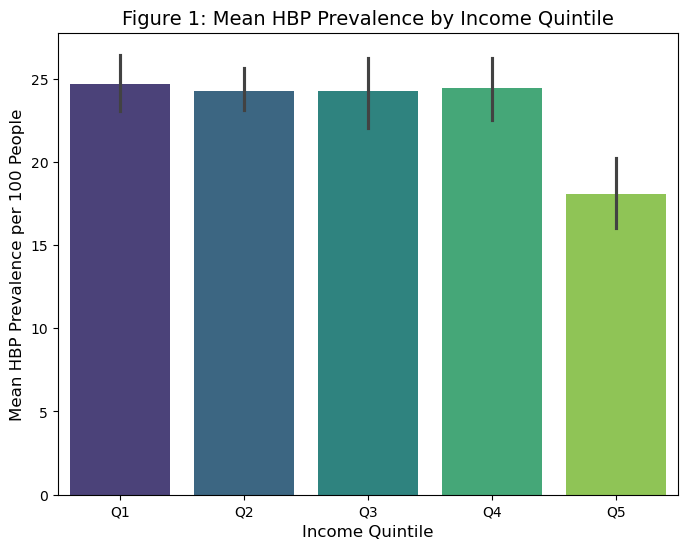

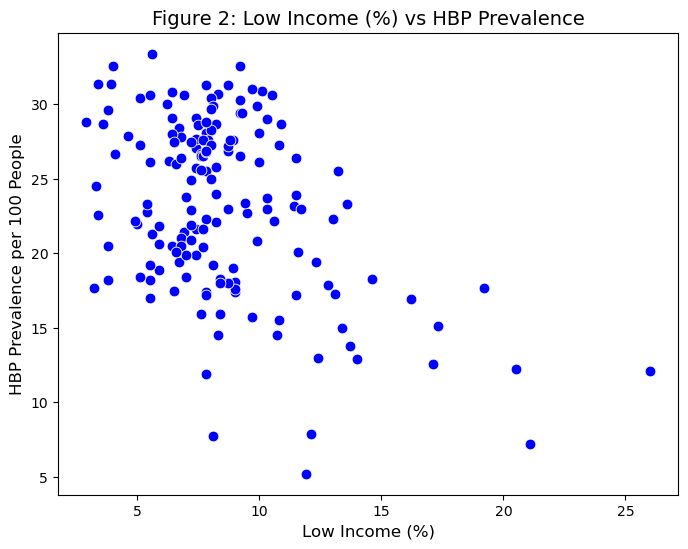

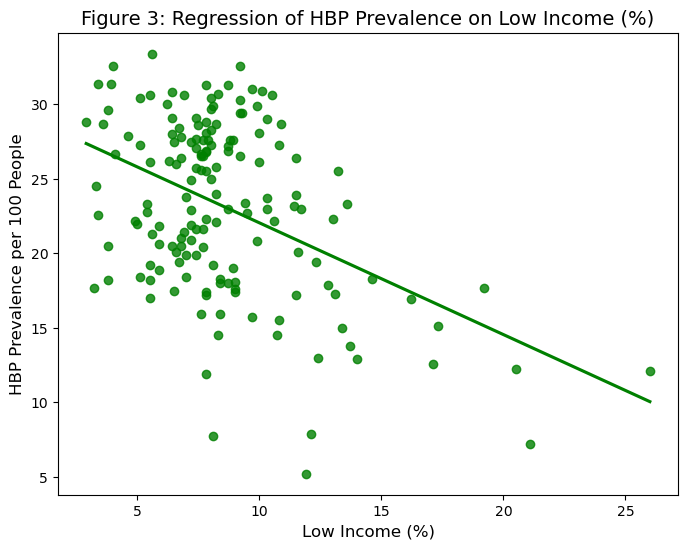

In [73]:
# Grouped statistics by income quintile for HBP prevalence
grouped_stats = income_hbp_df.groupby("Income Quintile")["HBP Prevalence per 100 people"].agg(["mean", "median", "std"])
print("\nGrouped Statistics by Income Quintile:")
print(grouped_stats)

# Bar plot: Mean HBP Prevalence by Income Quintile
plt.figure(figsize=(8,6))
sns.barplot(data=income_hbp_df, x='Income Quintile', y='HBP Prevalence per 100 people', errorbar='ci', palette="viridis")
plt.xlabel('Income Quintile', fontsize=12)
plt.ylabel('Mean HBP Prevalence per 100 People', fontsize=12)
plt.title('Figure 1: Mean HBP Prevalence by Income Quintile', fontsize=14)
plt.show()

# Scatter plot: Low Income (%) vs HBP Prevalence
plt.figure(figsize=(8,6))
sns.scatterplot(data=income_hbp_df, x='Low Income (%)', y='HBP Prevalence per 100 people', color='blue', s=60)
plt.xlabel('Low Income (%)', fontsize=12)
plt.ylabel('HBP Prevalence per 100 People', fontsize=12)
plt.title('Figure 2: Low Income (%) vs HBP Prevalence', fontsize=14)
plt.show()

# Regression plot: Low Income (%) vs HBP Prevalence
plt.figure(figsize=(8,6))
sns.regplot(data=income_hbp_df, x='Low Income (%)', y='HBP Prevalence per 100 people', ci=None, color='green')
plt.xlabel('Low Income (%)', fontsize=12)
plt.ylabel('HBP Prevalence per 100 People', fontsize=12)
plt.title('Figure 3: Regression of HBP Prevalence on Low Income (%)', fontsize=14)
plt.show()

**Visual Evidence Summary:**
- **Figure 1:** Bar plot shows the differences in mean HBP prevalence across income quintiles.
- **Figure 2:** Scatter plot demonstrates the relationship between Low Income (%) and HBP prevalence.
- **Figure 3:** Regression plot overlays the best-fit line on the data.

These plots indicate that income levels vary with HBP prevalence, setting the stage for regression analysis.

# 5. Statistical Modeling – Simple Regression
We now perform a simple OLS regression, modeling HBP prevalence as a function of low income percentage.


Simple Regression Model Summary:
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              29.5461      1.115     26.489      0.000      27.343      31.749
Q("Low Income (%)")    -0.7502      0.121     -6.193      0.000      -0.989      -0.511


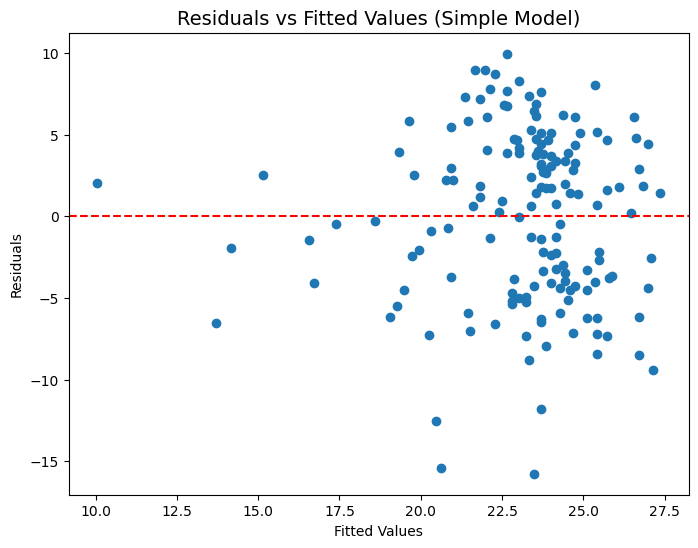

Simple Model R-squared: 0.19633408736542068


In [74]:
# Regression Analysis with Income Only

# Fit a linear regression model predicting HBP prevalence from Low Income (%)
reg_model = ols('Q("HBP Prevalence per 100 people") ~ Q("Low Income (%)")', data=income_hbp_df).fit()
print("\nSimple Regression Model Summary:")
print(reg_model.summary().tables[1])

# Plot Residuals vs Fitted Values for the simple model
plt.figure(figsize=(8,6))
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Simple Model)', fontsize=14)
plt.show()

print("Simple Model R-squared:", reg_model.rsquared)

**Model Diagnostics and Interpretation (Simple Model):**
- The simple regression model indicates that "Low Income (%)" alone explains about 20% of the variance (R² ≈ 0.20).
- The residuals versus fitted plot and Q-Q plot suggest that the model assumptions are reasonably met.
- Next, we extend the model by including additional predictors to enhance explanatory power.

# 6. Incorporating Additional Demographic Data
In this section, we load additional datasets (Immigrant Status and Visible Minority) and merge them with our main dataset.

In [75]:
# 7. Load and Clean Additional Demographic Data
# Immigrant Status Data 
immigrant_df = pd.read_excel('population_characteristics_Toronto_2021_7.xlsx', 
                             sheet_name='Immigrant Status', header=[9,10])
immigrant_subset = immigrant_df[['Neighb ID', 'Neighbourhood Name', 'Population who are \nImmigrants (%)']].copy()
immigrant_subset.columns = ['Neighb ID', 'Neighbourhood Name', 'Immigrant (%)']
immigrant_subset['Neighbourhood Name'] = immigrant_subset['Neighbourhood Name'].astype(str).str.strip()
print("\nImmigrant Status Data (first 5 rows):")
print(immigrant_subset.head())

# Visible Minority Data 
vm_df = pd.read_excel('population_characteristics_Toronto_2021_7.xlsx', 
                      sheet_name='Visible Minority_REVISED', header=[10,11])
vm_subset = vm_df[[('Neighb ID', 'Unnamed: 0_level_1'),
                   ('Neighbourhood Name', 'Unnamed: 1_level_1'),
                   ('   VISIBLE MINORITY POPULATIONS (%)', 'All Visible Minorities')]].copy()
vm_subset.columns = [" ".join(str(part).strip() for part in col_tuple) for col_tuple in vm_subset.columns]
print("\nFlattened Visible Minority Columns:")
print(vm_subset.columns.tolist())
vm_subset.rename(columns={
    "Neighb ID Unnamed: 0_level_1": "Neighb ID",
    "Neighbourhood Name Unnamed: 1_level_1": "Neighbourhood Name",
    "VISIBLE MINORITY POPULATIONS (%) All Visible Minorities": "Visible Minority (%)"
}, inplace=True)
vm_subset['Neighbourhood Name'] = vm_subset['Neighbourhood Name'].str.strip()
print("\nVisible Minority Data (first 5 rows):")
print(vm_subset.head())


Immigrant Status Data (first 5 rows):
   Neighb ID                 Neighbourhood Name  Immigrant (%)
0        2.0  Mount Olive-Silverstone-Jamestown           63.1
1        3.0       Thistletown-Beaumond Heights           52.9
2        4.0                    Rexdale-Kipling           46.4
3        5.0                   Elms-Old Rexdale           49.1
4        6.0      Kingsview Village-The Westway           50.6

Flattened Visible Minority Columns:
['Neighb ID Unnamed: 0_level_1', 'Neighbourhood Name Unnamed: 1_level_1', 'VISIBLE MINORITY POPULATIONS (%) All Visible Minorities']

Visible Minority Data (first 5 rows):
   Neighb ID                 Neighbourhood Name  Visible Minority (%)
0        1.0             West Humber-Clairville                  84.3
1        2.0  Mount Olive-Silverstone-Jamestown                  89.2
2        3.0       Thistletown-Beaumond Heights                  68.2
3        4.0                    Rexdale-Kipling                  57.7
4        5.0            

# 7. Merging Additional Data and Final Dataset Preparation
We merge the main analytical dataset with the additional demographic datasets and then export the final merged dataset.

In [76]:
# Merge Additional Demographic Data into Main Dataset
# Helper function to clean key columns
def clean_keys(df, key_cols):
    for col in key_cols:
        df[col] = df[col].astype(str).str.strip()
    return df

# Clean keys
income_hbp_df = clean_keys(income_hbp_df, ['Neighb ID', 'Neighbourhood Name'])
immigrant_subset = clean_keys(immigrant_subset, ['Neighb ID', 'Neighbourhood Name'])
vm_subset = clean_keys(vm_subset, ['Neighb ID', 'Neighbourhood Name'])

# Merge demographic data
merged_df = pd.merge(income_hbp_df, immigrant_subset, on=['Neighb ID', 'Neighbourhood Name'], how='left')
merged_df = pd.merge(merged_df, vm_subset, on=['Neighb ID', 'Neighbourhood Name'], how='left')

print("\nFinal Merged DataFrame (first 5 rows):")
print(merged_df.head())
print("\nMissing values in 'Immigrant (%)' and 'Visible Minority (%)':")
print(merged_df[['Immigrant (%)', 'Visible Minority (%)']].isna().sum())
merged_df = merged_df.dropna(subset=['Immigrant (%)'])


Final Merged DataFrame (first 5 rows):
  Neighb ID                 Neighbourhood Name  Low Income (%)  \
0       1.0             West Humber-Clairville             7.4   
1       2.0  Mount Olive-Silverstone-Jamestown             8.7   
2       3.0       Thistletown-Beaumond Heights             7.4   
3       4.0                    Rexdale-Kipling             7.5   
4       5.0                   Elms-Old Rexdale             7.6   

   HBP Prevalence per 100 people Income Quintile  Immigrant (%)  \
0                           27.1              Q2            NaN   
1                           26.9              Q4           63.1   
2                           29.1              Q2           52.9   
3                           28.6              Q2           46.4   
4                           26.7              Q2           49.1   

   Visible Minority (%)  
0                  84.3  
1                  89.2  
2                  68.2  
3                  57.7  
4                  69.3  

Mis

# 8. Statistical Modeling – Extended Regression
Here, we extend the regression model by including additional demographic predictors.

In [77]:
# Extended Regression Analysis with Additional Predictors
extended_model = ols(
    'Q("HBP Prevalence per 100 people") ~ Q("Low Income (%)") + Q("Immigrant (%)") + Q("Visible Minority (%)")',
    data=merged_df
).fit()
print("\nExtended Regression Model Summary (Coefficient Table):")
print(extended_model.summary().tables[1])
print("Extended Model R-squared:", extended_model.rsquared)


Extended Regression Model Summary (Coefficient Table):
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    17.9716      1.352     13.296      0.000      15.301      20.642
Q("Low Income (%)")          -1.0987      0.091    -12.008      0.000      -1.279      -0.918
Q("Immigrant (%)")            0.3093      0.053      5.847      0.000       0.205       0.414
Q("Visible Minority (%)")     0.0125      0.032      0.390      0.697      -0.051       0.076
Extended Model R-squared: 0.6392950079726221


**Extended Model Results:**
- **Low Income (%):** Negative coefficient (-1.10), indicating that an increase in low-income percentage is associated with a decrease in HBP prevalence.
- **Immigrant (%):** Positive coefficient (0.31), suggesting that a higher immigrant percentage increases HBP prevalence.
- **Visible Minority (%):** Not statistically significant.

The extended model explains approximately 64% of the variance in HBP prevalence.

# 9. Geospatial Mapping – Preparing Spatial Data
We now load the GeoJSON file containing Toronto neighbourhood boundaries and prepare it for merging.

In [78]:
# Geospatial Mapping Integration
# Load GeoJSON file containing Toronto neighborhood boundaries
neighbourhoods_gdf = gpd.read_file("Neighbourhoods.geojson")
neighbourhoods_gdf.rename(columns={'AREA_NAME': 'Neighbourhood Name'}, inplace=True)
neighbourhoods_gdf["Neighbourhood Name"] = neighbourhoods_gdf["Neighbourhood Name"].astype(str).str.strip()
print("\nGeoDataFrame (first 5 rows):")
print(neighbourhoods_gdf.head())


GeoDataFrame (first 5 rows):
   _id  AREA_ID  AREA_ATTR_ID  PARENT_AREA_ID AREA_SHORT_CODE AREA_LONG_CODE  \
0    1  2502366      26022881               0             174            174   
1    2  2502365      26022880               0             173            173   
2    3  2502364      26022879               0             172            172   
3    4  2502363      26022878               0             171            171   
4    5  2502362      26022877               0             170            170   

          Neighbourhood Name                        AREA_DESC  \
0  South Eglinton-Davisville  South Eglinton-Davisville (174)   
1              North Toronto              North Toronto (173)   
2         Dovercourt Village         Dovercourt Village (172)   
3   Junction-Wallace Emerson   Junction-Wallace Emerson (171)   
4         Yonge-Bay Corridor         Yonge-Bay Corridor (170)   

                         CLASSIFICATION CLASSIFICATION_CODE    OBJECTID  \
0  Not an NIA or Emergi

# 10. Geospatial Mapping – Visualization
Merge the geospatial data with the final merged dataset and create a choropleth map of HBP prevalence.


Merged GeoDataFrame (first 5 rows):
   _id  AREA_ID  AREA_ATTR_ID  PARENT_AREA_ID AREA_SHORT_CODE AREA_LONG_CODE  \
0    1  2502366      26022881               0             174            174   
1    2  2502365      26022880               0             173            173   
2    3  2502364      26022879               0             172            172   
3    4  2502363      26022878               0             171            171   
4    5  2502362      26022877               0             170            170   

          Neighbourhood Name                        AREA_DESC  \
0  South Eglinton-Davisville  South Eglinton-Davisville (174)   
1              North Toronto              North Toronto (173)   
2         Dovercourt Village         Dovercourt Village (172)   
3   Junction-Wallace Emerson   Junction-Wallace Emerson (171)   
4         Yonge-Bay Corridor         Yonge-Bay Corridor (170)   

                         CLASSIFICATION CLASSIFICATION_CODE    OBJECTID  \
0  Not an NIA or

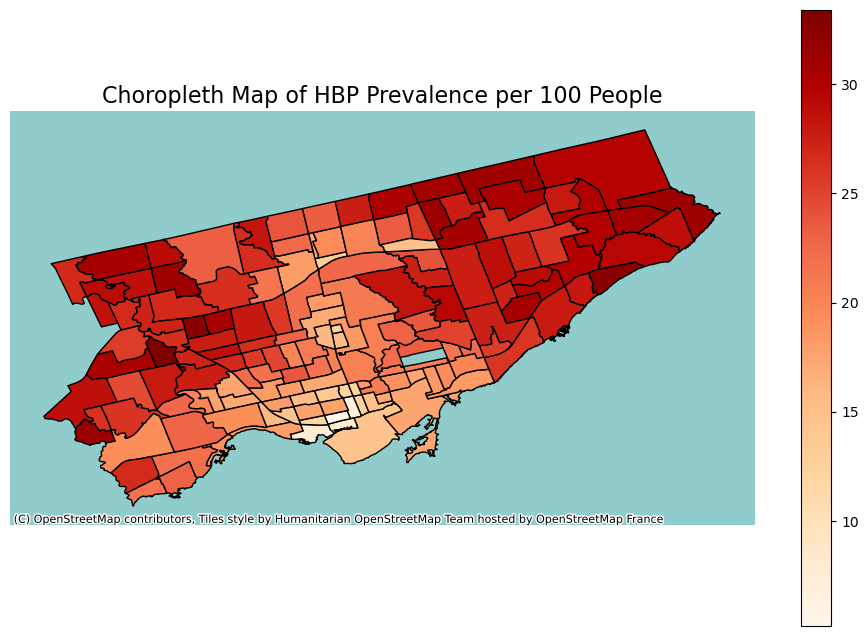

In [79]:
# Merge geospatial data with the merged attribute data
gdf_merged = neighbourhoods_gdf.merge(merged_df, on="Neighbourhood Name", how="left")
print("\nMerged GeoDataFrame (first 5 rows):")
print(gdf_merged.head())

# Create choropleth map for HBP Prevalence per 100 people
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf_merged.plot(column="HBP Prevalence per 100 people", cmap="OrRd", 
                legend=True, edgecolor="black", ax=ax)
ax.set_title("Choropleth Map of HBP Prevalence per 100 People", fontsize=16)
if gdf_merged.crs != "EPSG:3857":
    gdf_merged = gdf_merged.to_crs("EPSG:3857")
cx.add_basemap(ax, crs=gdf_merged.crs.to_string())
plt.axis("off")
plt.show()

**Choropleth Map Overview:**
The choropleth map displays HBP prevalence per 100 people across Toronto neighborhoods. The color scale (OrRd) illustrates the differences in prevalence, and the overlaid basemap provides geographic context. This spatial visualization reinforces the statistical findings by showing regional disparities.

# 11. Analysis Interpretation
Below is a brief interpretation of the findings:
- The regression analyses indicate a relationship between low income percentages and HBP prevalence.
- The extended model incorporating immigrant and visible minority percentages shows improved fit.
- The choropleth map reveals geographical disparities in HBP prevalence across Toronto.

# 12. Conclusion
In summary:
- Successfully merged multiple datasets and performed extensive data cleaning.
- EDA, regression models, and geospatial mapping provide insights into how socioeconomic factors relate to HBP prevalence.
- The results suggest that low-income areas, along with variations in demographic compositions, contribute to differences in health outcomes across Toronto.

Future work could include advanced spatial analyses (e.g., Moran’s I) to further quantify spatial clustering. This notebook represents a reproducible framework for analyzing health and socioeconomic data in Toronto.